In [2]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

0.9984358213507918
79.34199776000001
0.9990570257044541
76.76999783000001
0.9972902626160705
77.77399779999999
0.9984013135377303
73.49599792000001
0.9973637770265446
76.57799783
0.9964733709018948
78.15999779
0.9975684390717213
75.22399788
0.9989734065955868
79.80599775
0.9977470442045957
78.02599779
0.9979917014465085
77.6439978
0.9987791253978193
78.18599778000001
0.997784329851665
83.38199764000001
0.9961980581824783
78.54799778
0.9988688067616268
74.2239979
0.9967142475743594
80.24599773
0.9989829260597062
76.35399784
0.9982623699419257
76.72999783
0.9963962940147746
79.01399777
0.9983980159053057
77.9859978
0.9974583476913762
76.66199782999999


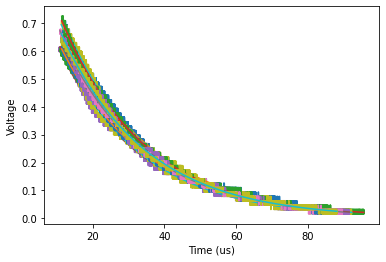

In [7]:
def objective(x,a,b):
    return a*np.power(b,x)

data_path = '20211104-0002/'
data_files = glob.glob(data_path + '*.csv')
ring_downs = []

for i in data_files:
    data = pd.read_csv(i, skiprows=1) 
    start_full = data.loc[(data['(V)'] == max(data['(V)']))].last_valid_index()
    end_full = data.loc[(data['(V)']== 0) & (data['(us)'] >= 0)].first_valid_index()
    
    #need to do 0.9 and 0.1 times the voltage and find the times for those

    size = end_full - start_full
    scale = np.round(0.1*size)
    start = int(start_full + scale)
    end = int(end_full - scale)

    time = data['(us)']
    time = time[start:end]
    voltage = data['(V)']
    voltage = voltage[start:end]

    popt, pcov = curve_fit(objective, time, voltage)
    
    residuals = voltage - objective(time, *popt)
    res_ss = np.sum(residuals**2)
    ss_tot = np.sum((voltage - np.mean(voltage))**2)
    r_squared = 1 - (res_ss / ss_tot)
    print(r_squared)

    ringdown = max(time) - min(time)
    print(ringdown)
    ring_downs.append(ringdown)
    
    plt.plot(time, voltage)
    plt.plot(time, objective(time, *popt))
    plt.xlabel('Time (us)')
    plt.ylabel('Voltage')


In [8]:
print(np.mean(ring_downs))

77.7075978025
